In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

,f0,f1,f2,f3,f4,choice
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.499501,0.500137,0.498480,0.499435,0.501197,-0.341152
std,0.289803,0.289258,0.290220,0.287753,0.289187,0.193437
min,0.000036,0.000103,0.000170,0.000037,0.000002,-0.894081
25%,0.248863,0.249847,0.246880,0.249468,0.250188,-0.467807
50%,0.500036,0.500011,0.499968,0.500047,0.499994,-0.342081
75%,0.753105,0.748984,0.751032,0.747607,0.752229,-0.193800
max,0.999966,0.999980,0.999984,0.999975,0.999979,0.270935


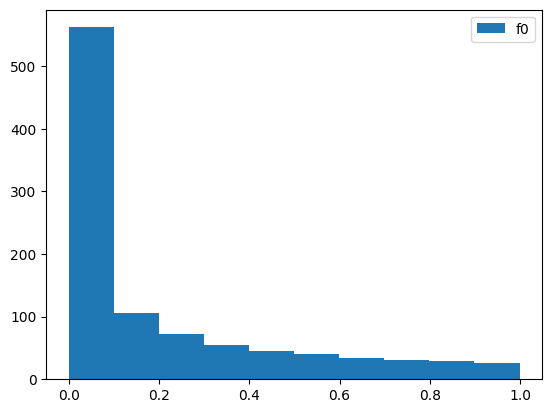

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import mse
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr, x_alt, feature_names):
    x_arr = np.concatenate([x_arr, x_alt], axis=1) if x_alt is not None else x_arr
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)

def create_functional_effects(x: np.ndarray, n_utility: int, f_per_utility: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    
    for i in range(n_utility):
        effects[:, i] = np.prod(x[:, i * f_per_utility:(i + 1) * f_per_utility], axis=1)
            
    return effects

def apply_functional_effects(x: np.ndarray, n_utility: int, f_per_utility: int) -> pd.DataFrame:
    """
    Apply functional effects to the input data and return a DataFrame.
    """
    effects = create_functional_effects(x, n_utility, f_per_utility)
    feature_names = [f"f{i}" for i in range(n_utility)]
    
    return pd.DataFrame(effects, columns=feature_names)

def add_alt_spec_features(dataset_transformed: pd.DataFrame, x_alt: np.ndarray, n_utility: int, coeff: list) -> pd.DataFrame:
    """
    Add alternative specific features to the transformed dataset.
    """
    
    for i in range(n_utility):
        dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, i]
    
    return dataset_transformed

def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    if regression:
        return u[0]
    else:
        return np.random.choice(u.shape[0], size=1, p=softmax(u))[0]

n_utility = 1
regression = n_utility == 1
f_per_utility = 4
x_arr = generate_x(20000, n_utility * f_per_utility, 0.5, 0.5)
x_alt = generate_x(20000, 1, 0.5, 0.5)
x_arr_test = generate_x(10000, n_utility * f_per_utility, 0.5, 0.5)
x_alt_test = generate_x(10000, 1, 0.5, 0.5)
sp = np.array(
    [
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.34, 0.5, 0.55, 1],
        [0, 0.2, 0.4, 0.8, 1],
        [0, 0.1, 0.55, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
    ]
)
betas = np.array(
    [
        [1, 2, 0.5, 1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 0, 0],
        [3, -2, 0.5, -1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 1, 1, 0],
        [1, -2, 0.5, -1],
        [-0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 5, 0],
        [1, 1, 0.9, -1],
        [0.5, -1, 0.5, 1],
        [-0.5, -0.5, 2, -3],
        [0, -1, 0, 0],
    ]
)
intercept = [-0.5, -1.5, 0.5, -1, 0, -2, 1, -2, 1, -1, -0.5, 0.5, -2, 0, 0, 0.5]
coeff = [-1]

ind = [i for i in range(4 * n_utility) if i % 4 < f_per_utility]
sp = [sp[i] for i in ind]
betas = [betas[i] for i in ind]
intercept = [intercept[i] for i in ind]

feature_names = [f"f{i}" for i in range(f_per_utility*n_utility)]
if x_alt.shape[1] > 0:
    feature_names += [f"f{n_utility * f_per_utility + i}" for i in range(x_alt.shape[1])]

u_idx = [(0, 1) for _ in range(n_utility)]

x_plot = np.linspace(1e-4, 1, 4000).reshape(-1, f_per_utility)
y_plot = apply_functional_effects(x_plot, n_utility, f_per_utility)
plt.hist(y_plot, label=feature_names[0], linewidth=2)

plt.legend()

dataset = create_dataset(x_arr, x_alt, feature_names)
dataset_transf = apply_functional_effects(x_arr, n_utility, f_per_utility)
dataset_transf = add_alt_spec_features(dataset_transf, x_alt, n_utility, coeff)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, x_alt_test, feature_names)
dataset_test_transf = apply_functional_effects(x_arr_test, n_utility, f_per_utility)
dataset_test_transf = add_alt_spec_features(dataset_test_transf, x_alt_test, n_utility, coeff)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

In [3]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {0: ["f4"]}
socio_demo_chars = [f"f{i}" for i in range(f_per_utility * n_utility)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [4]:
X_train

,f0,f1,f2,f3,f4
0,0.274407,0.357595,0.301382,0.272442,0.005548
1,0.211827,0.322947,0.218794,0.445887,0.000885
2,0.481831,0.191721,0.395863,0.264447,0.077528
3,0.284022,0.462798,0.035518,0.043565,0.158381
4,0.010109,0.416310,0.389078,0.435006,0.325922
...,...,...,...,...,...
19995,0.810728,0.753752,0.745902,0.774003,0.862961
19996,0.923679,0.669300,0.546208,0.736437,0.753760
19997,0.506963,0.817195,0.882666,0.684444,0.905066
19998,0.712733,0.838928,0.594896,0.569223,0.775516


In [5]:
model = "RUMBoost"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = True
args.model = model
args.dataset = "synthetic"
args.learning_rate = 1

model = RUMBoost(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    args=args,
    )

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = mse(preds, y_val)



/home/nicolas-salvade/panel-data/src/rumboost/rumboost.py:2680: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[1]------NCE value on train set : 0.0812
---------NCE value on test set 1: 0.0809
[11]-----NCE value on train set : 0.0599
---------NCE value on test set 1: 0.0599
Early stopping at iteration 4, with a best score on test set of 0.050818441749020025, and on train set of 0.06252482634233693


In [6]:
model.model.boosters[1].dump_model()

{'name': 'tree',
 'version': 'v4',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 3,
 'average_output': False,
 'feature_names': ['f0', 'f1', 'f2', 'f3'],
 'monotone_constraints': [],
 'feature_infos': {'f0': {'min_value': 3.6224819246089e-05,
   'max_value': 0.9999657042121609,
   'values': []},
  'f1': {'min_value': 0.000103474241032131,
   'max_value': 0.9999797766952077,
   'values': []},
  'f2': {'min_value': 0.000170431236180435,
   'max_value': 0.9999841081817834,
   'values': []},
  'f3': {'min_value': 3.684971655304459e-05,
   'max_value': 0.9999752891477869,
   'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 31,
   'num_cat': 0,
   'shrinkage': 0.1,
   'tree_structure': {'split_index': 0,
    'split_feature': 1,
    'split_gain': 706.1699829101562,
    'threshold': 0.4976817867522788,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': -0.0682305,
    'internal_weight':

In [10]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf,
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf,
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 0.06252482634233693, Best Val Loss: 0.050818441749020025
Test Loss: 0.005663043495514475


/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


(array([ 356.,  998., 1171.,  925., 5652.,  429.,  241.,  143.,   58.,
          27.]),
 array([-0.40267445, -0.34038372, -0.27809299, -0.21580226, -0.15351153,
        -0.0912208 , -0.02893007,  0.03336066,  0.09565139,  0.15794213,
         0.22023286]),
 <BarContainer object of 10 artists>)

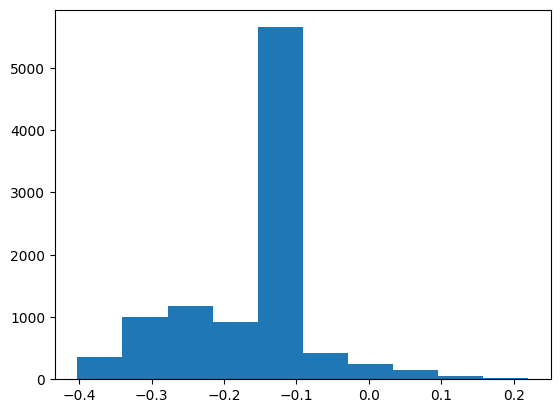

In [8]:
plt.hist(learnt_fct_intercepts_test)

In [9]:
model = "TasteNet"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = True
args.model = model
args.dataset = "synthetic"


model = TasteNet(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    num_latent_vals=None,
    args=args,
)

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = mse(preds, y_val)



/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (256) at non-singleton dimension 1